
# Intro to Orbital Mechanics (Beginner-Friendly)

This notebook teaches the basics of orbital mechanics using **manual integrators** and clear equations.

We'll cover:
1. **Newton's Second Law** and **Newton's Law of Gravitation**.
2. Implement a **2D circular orbit** using **explicit Euler**.
3. Add a **simple atmospheric drag** term.
4. Add a **solar radiation pressure (SRP)** term.
5. **Extend to 3D** with the same code by changing the state dimension.
6. Turn off drag & SRP and switch to **RK4**, then **compare energy conservation** (Euler vs RK4).

> Throughout, we show the **equations** before implementing them in code.



## 1) Newton's Second Law

Newton's Second Law (vector form):
\begin{equation}
\mathbf{F} = m \mathbf{a},
\quad \text{so} \quad
\mathbf{a} = \frac{\mathbf{F}}{m}.
\end{equation}

We'll build the **force model** $\mathbf{F}$ piece by piece: gravity, then (optionally) drag and solar radiation pressure.



## 2) Newton's Law of Gravitation

For a point mass orbiting a central body (e.g., a satellite around Earth), the gravitational force is
\begin{equation}
\mathbf{F}_g = - \frac{\mu m}{r^3} \mathbf{r},
\end{equation}
where
- $\mu = GM$ is the **standard gravitational parameter**,
- $\mathbf{r}$ is the position vector from the central body to the spacecraft,
- $r = \|\mathbf{r}\|$.

Thus the gravitational acceleration is
\begin{equation}
\mathbf{a}_g = \frac{\mathbf{F}_g}{m} = - \frac{\mu}{r^3} \mathbf{r}.
\end{equation}


In [16]:

# --- Imports and constants ---
import numpy as np
import matplotlib.pyplot as plt

# Physical constants (SI)
mu_earth = 3.986004418e14      # Earth's gravitational parameter [m^3/s^2]
R_earth  = 6371e3              # Earth radius [m]

# For drag (simple exponential model)
rho0 = 1.225                   # Sea-level density [kg/m^3]
H    = 8500.0                  # Scale height [m] (very rough)
Cd   = 2.2                     # Drag coefficient (typical for small sats)
A    = 0.02                    # Reference area [m^2] (example)
m    = 5.0                     # Spacecraft mass [kg] (example)

# For SRP
P0 = 4.56e-6                   # Solar radiation pressure at 1 AU [N/m^2]
Cr = 1.5                       # Reflectivity / coefficient (1 ~ absorbing, 1.3-1.8 reflective)
A_srp = 0.02                   # Effective SRP area [m^2] (example)
# Assume the Sun-line direction is fixed along +x for the demo (Earth-centered sim, simplification)
sun_dir_2d = np.array([1.0, 0.0])   # Unit vector (2D case)
sun_dir_3d = np.array([1.0, 0.0, 0.0])  # Unit vector (3D case)

def norm(x):
    return np.linalg.norm(x)


In [17]:
# --- Plotting utilities & style ---
import matplotlib as mpl
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D  # enables 3D projection

# Global style tweaks (soft grid, readable fonts)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    plt.style.use('seaborn-darkgrid')
mpl.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
})

# Global RAAN-like visual shift (rotate plots about +z)
APPLY_RAAN_SHIFT = True
RAAN_SHIFT_DEG  = 90.0

def rotate_xy(x, y, deg=RAAN_SHIFT_DEG, enabled=APPLY_RAAN_SHIFT):
    import numpy as np
    if not enabled:
        return x, y
    th = np.deg2rad(deg)
    c, s = np.cos(th), np.sin(th)
    xr = c*x - s*y
    yr = s*x + c*y
    return xr, yr

def rotate_xyz(x, y, z, deg=RAAN_SHIFT_DEG, enabled=APPLY_RAAN_SHIFT):
    xr, yr = rotate_xy(x, y, deg=deg, enabled=enabled)
    return xr, yr, z

def draw_earth_2d(ax, R=R_earth, facecolor='#4C78A8', edgecolor='#2F3B52', alpha=0.25):
    """Draw a filled Earth disk centered at origin in 2D plots."""
    earth = mpatches.Circle((0, 0), R, facecolor=facecolor, edgecolor=edgecolor, linewidth=1.0, alpha=alpha)
    ax.add_patch(earth)

def set_equal_xy(ax, margin=1.05):
    """Set equal aspect with a small margin for 2D axes."""
    ax.set_aspect('equal', 'box')
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    xspan = xlim[1]-xlim[0]; yspan = ylim[1]-ylim[0]
    span = max(xspan, yspan) * margin
    xc = 0.5*(xlim[0]+xlim[1]); yc = 0.5*(ylim[0]+ylim[1])
    ax.set_xlim(xc - span/2, xc + span/2)
    ax.set_ylim(yc - span/2, yc + span/2)

def draw_earth_3d(ax, R=R_earth, color='#4C78A8', alpha=0.30, resolution=50):
    """Draw a shaded Earth sphere centered at origin in 3D axes with semi-transparency."""
    import numpy as np
    u = np.linspace(0, 2*np.pi, resolution)
    v = np.linspace(0, np.pi, resolution//2)
    x = R * np.outer(np.cos(u), np.sin(v))
    y = R * np.outer(np.sin(u), np.sin(v))
    z = R * np.outer(np.ones_like(u), np.cos(v))
    # Light shading via colormap based on z
    cmap = plt.get_cmap('Blues')
    z_norm = (z - z.min()) / (z.max() - z.min() + 1e-9)
    facecolors = cmap(0.4 + 0.6*z_norm)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=facecolors, linewidth=0, antialiased=True, shade=True, alpha=alpha)
    # Optional: draw equator and prime meridian for reference
    phi = np.linspace(0, 2*np.pi, 361)
    ax.plot(R*np.cos(phi), R*np.sin(phi), 0*phi, color='#2F3B52', linewidth=0.8, alpha=0.35)
    th = np.linspace(-np.pi/2, np.pi/2, 181)
    ax.plot(R*np.cos(th), 0*th, R*np.sin(th), color='#2F3B52', linewidth=0.8, alpha=0.35)

def set_equal_3d(ax, center=(0,0,0), radius=None):
    """Set 3D axes to equal scale. If radius is None, infer from current limits."""
    import numpy as np
    if radius is None:
        xlim = ax.get_xlim3d(); ylim = ax.get_ylim3d(); zlim = ax.get_zlim3d()
        xspan = xlim[1]-xlim[0]; yspan = ylim[1]-ylim[0]; zspan = zlim[1]-zlim[0]
        radius = 0.5 * max(xspan, yspan, zspan)
        center = (0.5*(xlim[0]+xlim[1]), 0.5*(ylim[0]+ylim[1]), 0.5*(zlim[0]+zlim[1]))
    cx, cy, cz = center
    ax.set_xlim3d(cx - radius, cx + radius)
    ax.set_ylim3d(cy - radius, cy + radius)
    ax.set_zlim3d(cz - radius, cz + radius)
    # For modern Matplotlib, also set equal box aspect
    try:
        ax.set_box_aspect([1,1,1])
    except Exception:
        pass


## 3) Explicit Euler Integrator (2D Circular Orbit)

**Explicit Euler** steps the state forward as:
\begin{align}
\mathbf{v}_{k+1} &= \mathbf{v}_k + \mathbf{a}(\mathbf{r}_k, \mathbf{v}_k)\,\Delta t, \\
\mathbf{r}_{k+1} &= \mathbf{r}_k + \mathbf{v}_k\,\Delta t.
\end{align}

We'll start with **gravity only** and initialize a near-circular orbit.
The circular speed at radius $r_0$ is
\begin{equation}
v_0 = \sqrt{\frac{\mu}{r_0}}.
\end{equation}


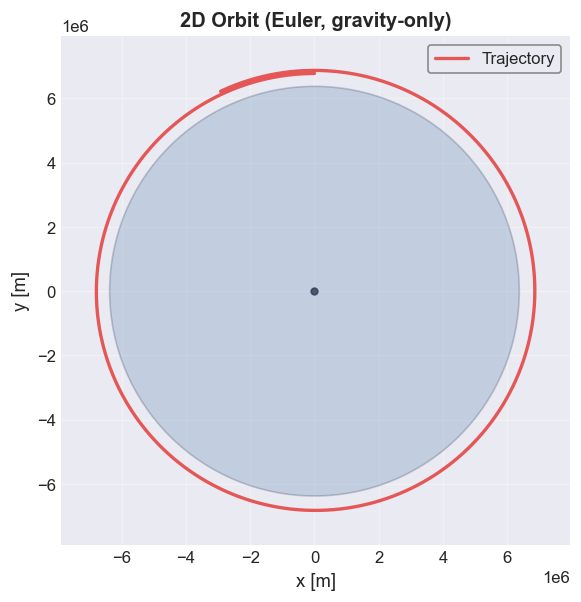

In [18]:
# --- 2D orbit with explicit Euler (gravity only) ---
# WORKED EXAMPLE
def accel_gravity(r, mu=mu_earth):
    rr = norm(r)
    return -mu * r / rr**3
# WORKED EXAMPLE
def euler_step(r, v, dt, a_func):
    a = a_func(r, v)
    v_next = v + a * dt
    r_next = r + v * dt
    return r_next, v_next

def propagate_euler_2d(r0, v0, t_end, dt, a_func):
    n = int(np.ceil(t_end/dt))
    rs = np.zeros((n+1, 2))
    vs = np.zeros((n+1, 2))
    ts = np.zeros(n+1)
    rs[0], vs[0] = r0.copy(), v0.copy()
    for k in range(n):
        rs[k+1], vs[k+1] = euler_step(rs[k], vs[k], dt, a_func)
        ts[k+1] = ts[k] + dt
    return ts, rs, vs

# Initialize a circular LEO at 400 km altitude
alt = 400e3
r0_mag = R_earth + alt
r0 = np.array([r0_mag, 0.0])
v0 = np.array([0.0, np.sqrt(mu_earth/r0_mag)])

t_end = 6000.0  # seconds (~1.7 hours is ~6180 s for LEO period, here we do a short arc)
dt    = 1.0

# Gravity-only acceleration (2D)
def a_grav_only(r, v):
    return accel_gravity(r, mu_earth)

ts, rs, vs = propagate_euler_2d(r0, v0, t_end, dt, a_grav_only)

# Pretty 2D plot with filled Earth
fig, ax = plt.subplots(figsize=(5.5,5.5))
draw_earth_2d(ax, R_earth)
x, y = rs[:,0], rs[:,1]
x, y = rotate_xy(x, y)  # visual RAAN shift
ax.plot(x, y, color='#E45756', lw=2.0, label='Trajectory')
ax.plot([0],[0],'o', color='#2F3B52', ms=4, alpha=0.8)  # Earth center marker
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('2D Orbit (Euler, gravity-only)')
ax.legend(loc='upper right')
set_equal_xy(ax)
plt.show()


## 4) Add a Simple Atmospheric Drag Term

We'll use a basic **exponential atmosphere**:
\begin{equation}
\rho(h) = \rho_0 \exp\!\left(-\frac{h}{H}\right), \quad h = r - R_\oplus.
\end{equation}

The **drag acceleration** (vector form) is
\begin{equation}
\mathbf{a}_d = -\frac{1}{2}\,\frac{C_d A}{m}\,\rho\,\|\mathbf{v}\|\,\mathbf{v}.
\end{equation}

So our total acceleration becomes
\begin{equation}
\mathbf{a} = \mathbf{a}_g + \mathbf{a}_d.
\end{equation}


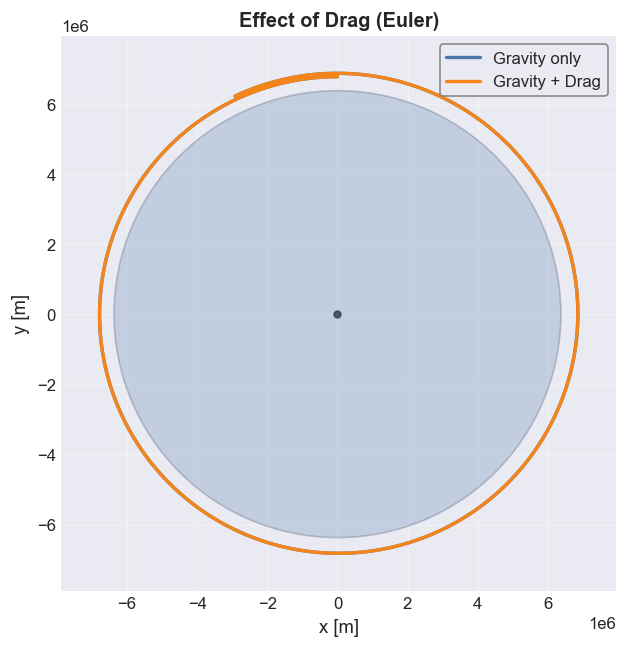

In [19]:
# --- Drag model (very simple) ---

# WORKED EXAMPLE
def density_exponential(r_vec):
    rmag = norm(r_vec)
    h = max(0.0, rmag - R_earth)
    return rho0 * np.exp(-h / H)

# WORKED EXAMPLE
def accel_drag(r, v):
    rho = density_exponential(r)
    vmag = norm(v)
    if vmag == 0.0:
        return np.zeros_like(r)
    return -0.5 * (Cd * A / m) * rho * vmag * v
# WORKED EXAMPLE
def a_grav_drag(r, v):
    return accel_gravity(r, mu_earth) + accel_drag(r, v)

ts_d, rs_d, vs_d = propagate_euler_2d(r0, v0, t_end, dt, a_grav_drag)

# Styled comparison plot with filled Earth
fig, ax = plt.subplots(figsize=(6,6))
draw_earth_2d(ax, R_earth)
xg, yg = rotate_xy(rs[:,0],  rs[:,1])
xd, yd = rotate_xy(rs_d[:,0],rs_d[:,1])
ax.plot(xg, yg,  label='Gravity only', color='#4C78A8', lw=2.0)
ax.plot(xd, yd,  label='Gravity + Drag', color='#F58518', lw=2.0)
ax.plot([0],[0],'o', color='#2F3B52', ms=4, alpha=0.8)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Effect of Drag (Euler)')
ax.legend(loc='upper right')
set_equal_xy(ax)
plt.show()


## 5) Add Solar Radiation Pressure (SRP)

The **SRP force** magnitude at 1 AU is approximately $P_0 \, C_r A_{\text{srp}}$ in the direction **away from the Sun**.
We model SRP acceleration as
\begin{equation}
\mathbf{a}_{\text{srp}} = \frac{P_0 \, C_r \, A_{\text{srp}}}{m} \,\hat{\mathbf{s}},
\end{equation}
where $\hat{\mathbf{s}}$ is the Sun-line unit vector (here we **simplify** and keep it fixed along $+\hat{\mathbf{x}}$).

Total acceleration now:
\begin{equation}
\mathbf{a} = \mathbf{a}_g + \mathbf{a}_d + \mathbf{a}_{\text{srp}}.
\end{equation}

> **Note:** In reality, $\hat{\mathbf{s}}$ changes over time as Earth orbits the Sun and due to spacecraft attitude. This fixed-direction approximation is to illustrate the concept.


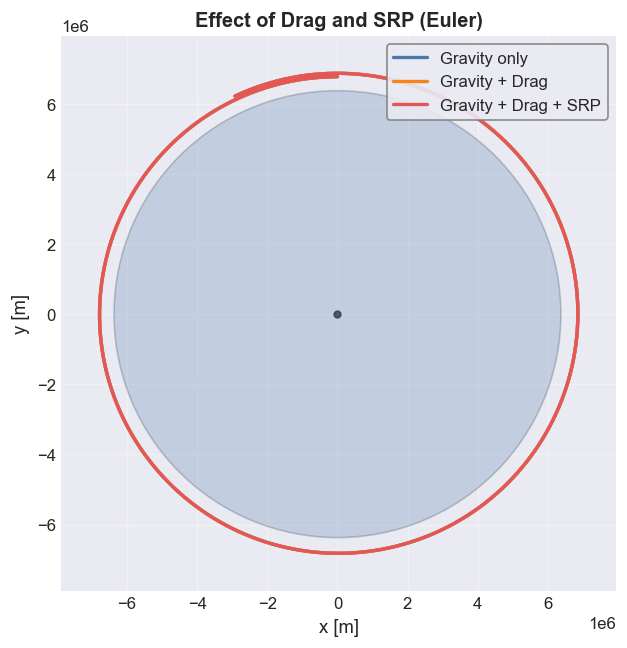

In [20]:
# WORKED EXAMPLE
def accel_srp_fixed():
    # Constant acceleration direction (unit): +x
    return (P0 * Cr * A_srp / m) * sun_dir_2d

# WORKED EXAMPLE
def a_grav_drag_srp(r, v):
    return accel_gravity(r, mu_earth) + accel_drag(r, v) + accel_srp_fixed()

ts_s, rs_s, vs_s = propagate_euler_2d(r0, v0, t_end, dt, a_grav_drag_srp)

# Styled SRP comparison plot with filled Earth
fig, ax = plt.subplots(figsize=(6,6))
draw_earth_2d(ax, R_earth)
xg, yg = rotate_xy(rs[:,0],   rs[:,1])
xd, yd = rotate_xy(rs_d[:,0], rs_d[:,1])
xs, ys = rotate_xy(rs_s[:,0], rs_s[:,1])
ax.plot(xg, yg, label='Gravity only', color='#4C78A8', lw=2.0)
ax.plot(xd, yd, label='Gravity + Drag', color='#F58518', lw=2.0)
ax.plot(xs, ys, label='Gravity + Drag + SRP', color='#E45756', lw=2.0)
ax.plot([0],[0],'o', color='#2F3B52', ms=4, alpha=0.8)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Effect of Drag and SRP (Euler)')
ax.legend(loc='upper right')
set_equal_xy(ax)
plt.show()


## 6) Extend to 3D by Changing State Dimension

The same integrator logic works in **3D**; we only change the dimension of vectors.
Equations are identical in vector form.

We'll re-use the Euler step for a short 3D trajectory (gravity only), starting from an inclined orbit.


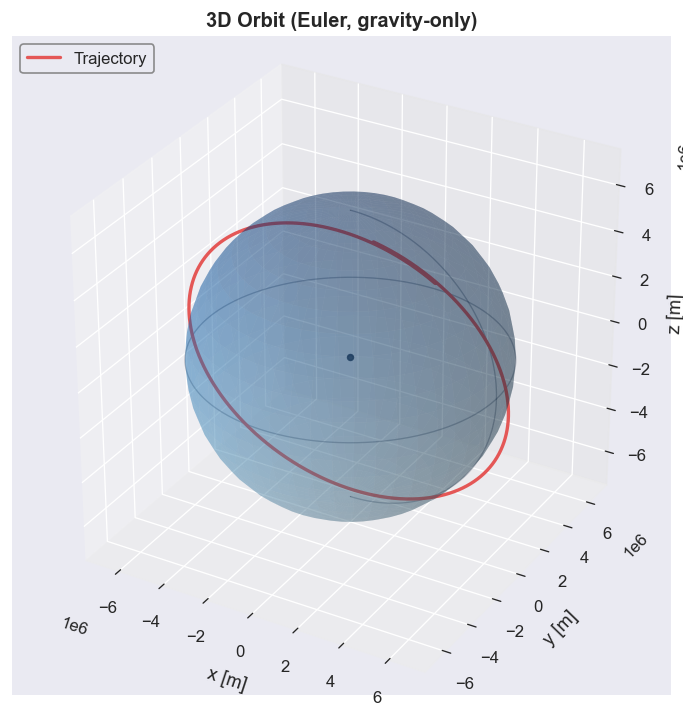

In [21]:
# --- 3D Euler propagation (gravity only) ---
def propagate_euler_nd(r0, v0, t_end, dt, a_func):
    n = int(np.ceil(t_end/dt))
    dim = r0.shape[0]
    rs = np.zeros((n+1, dim))
    vs = np.zeros((n+1, dim))
    ts = np.zeros(n+1)
    rs[0], vs[0] = r0.copy(), v0.copy()
    for k in range(n):
        a = a_func(rs[k], vs[k])
        vs[k+1] = vs[k] + a * dt
        rs[k+1] = rs[k] + vs[k] * dt
        ts[k+1] = ts[k] + dt
    return ts, rs, vs

# 3D inclined orbit initial state (e.g. 30 deg inclination)
inc = np.deg2rad(30.0)
r0_3d = np.array([r0_mag, 0.0, 0.0])
v_circ = np.sqrt(mu_earth / r0_mag)
v0_3d = np.array([0.0, v_circ*np.cos(inc), v_circ*np.sin(inc)])

def a_grav_only_3d(r, v):
    rr = norm(r)
    return -mu_earth * r / rr**3

ts3, rs3, vs3 = propagate_euler_nd(r0_3d, v0_3d, t_end, dt, a_grav_only_3d)

# True 3D plot with Earth sphere
fig = plt.figure(figsize=(7.5,6))
ax = fig.add_subplot(111, projection='3d')
draw_earth_3d(ax, R_earth, alpha=0.30)
x3, y3, z3 = rs3[:,0], rs3[:,1], rs3[:,2]
x3, y3, z3 = rotate_xyz(x3, y3, z3)
ax.plot(x3, y3, z3, color='#E45756', lw=2.0, label='Trajectory')
ax.scatter([0],[0],[0], color='#2F3B52', s=12, alpha=0.9)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Orbit (Euler, gravity-only)')
# Set limits around the orbit to provide context
max_r = np.max(np.linalg.norm(np.vstack((x3,y3,z3)).T, axis=1))
pad = 0.1 * max_r
ax.set_xlim(-max_r-pad, max_r+pad)
ax.set_ylim(-max_r-pad, max_r+pad)
ax.set_zlim(-max_r-pad, max_r+pad)
set_equal_3d(ax)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Part 2) RK4 and Energy Conservation (No Drag, No SRP)

Now we **turn off drag and SRP** and compare **Explicit Euler** vs **RK4** integrators on energy conservation.

**Specific mechanical energy** in a two-body problem is
\begin{equation}
\varepsilon = \frac{v^2}{2} - \frac{\mu}{r}.
\end{equation}

**RK4** step:
\begin{align}
\mathbf{k}_1 &= f(\mathbf{y}_k),\\
\mathbf{k}_2 &= f(\mathbf{y}_k + \tfrac{\Delta t}{2}\mathbf{k}_1),\\
\mathbf{k}_3 &= f(\mathbf{y}_k + \tfrac{\Delta t}{2}\mathbf{k}_2),\\
\mathbf{k}_4 &= f(\mathbf{y}_k + \Delta t\,\mathbf{k}_3),\\
\mathbf{y}_{k+1} &= \mathbf{y}_k + \frac{\Delta t}{6}\left(\mathbf{k}_1 + 2\mathbf{k}_2 + 2\mathbf{k}_3 + \mathbf{k}_4\right).
\end{align}

We'll integrate the **gravity-only** equations in **3D** with both methods and compare $\varepsilon(t)$, then visualize the resulting 3D orbits.

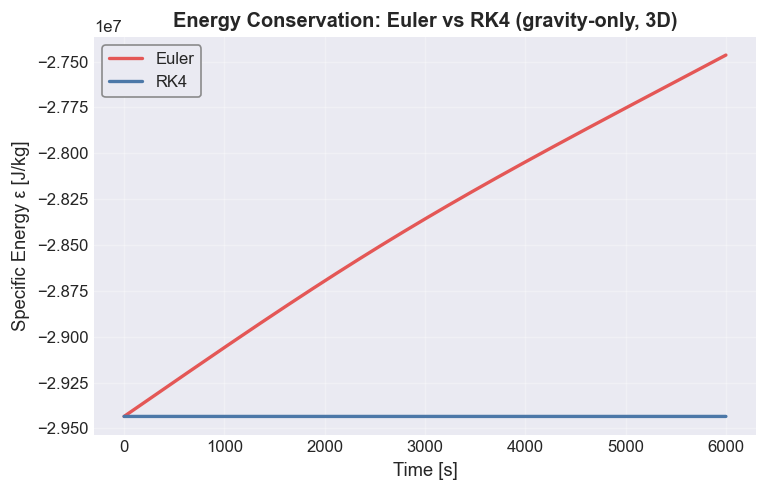

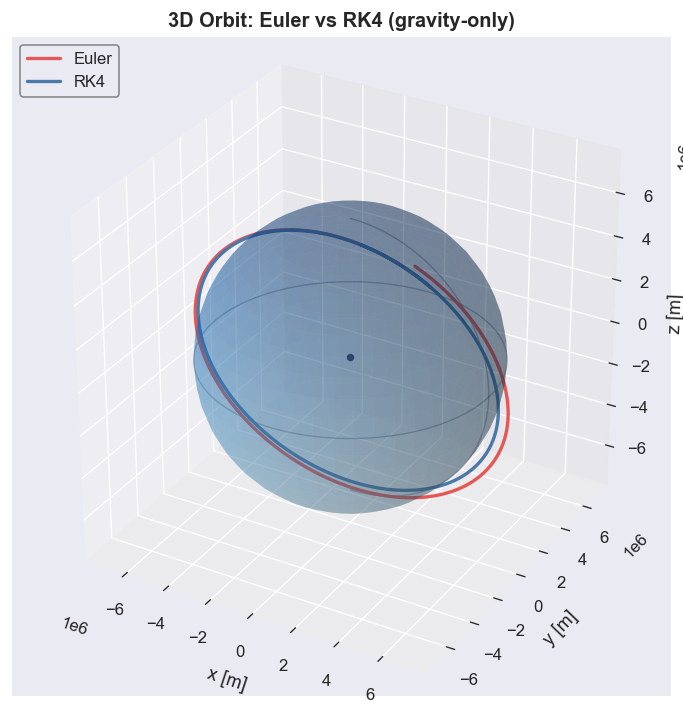

In [22]:
# --- Gravity-only dynamics in 3D state-space form for RK4 ---
def f_state_3d(y):
    # y = [x, y, z, vx, vy, vz]
    r = y[:3]
    v = y[3:]
    a = -mu_earth * r / (norm(r)**3)
    return np.hstack((v, a))

def rk4_step(y, dt, f):
    k1 = f(y)
    k2 = f(y + 0.5*dt*k1)
    k3 = f(y + 0.5*dt*k2)
    k4 = f(y + dt*k3)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def propagate_method(y0, t_end, dt, stepper, f):
    n = int(np.ceil(t_end/dt))
    ys = np.zeros((n+1, len(y0)))
    ts = np.zeros(n+1)
    ys[0] = y0.copy()
    for k in range(n):
        ys[k+1] = stepper(ys[k], dt, f)
        ts[k+1] = ts[k] + dt
    return ts, ys

def specific_energy(r, v):
    return 0.5*np.dot(v, v) - mu_earth/norm(r)

# Initial 3D state: same radius and speed as 2D, with an inclination (e.g., 30 deg)
inc_energy = np.deg2rad(30.0)
r0_vec = np.array([r0_mag, 0.0, 0.0])
v_circ = np.sqrt(mu_earth / r0_mag)
v0_vec = np.array([0.0, v_circ*np.cos(inc_energy), v_circ*np.sin(inc_energy)])
y0_3d = np.hstack((r0_vec, v0_vec))

# Euler applied to the same 3D state dynamics
def euler_state_step(y, dt, f):
    return y + dt * f(y)

t_end_energy = 6000.0
dt_energy    = 5.0

ts_e, ys_e = propagate_method(y0_3d, t_end_energy, dt_energy, euler_state_step, f_state_3d)
ts_r, ys_r = propagate_method(y0_3d, t_end_energy, dt_energy, rk4_step, f_state_3d)

# Energy histories
E_e = np.array([specific_energy(ye[:3], ye[3:]) for ye in ys_e])
E_r = np.array([specific_energy(yr[:3], yr[3:]) for yr in ys_r])

# Plot energy vs time
plt.figure(figsize=(6.5,4.2))
plt.plot(ts_e, E_e, label='Euler', color='#E45756', lw=2.0)
plt.plot(ts_r, E_r, label='RK4', color='#4C78A8', lw=2.0)
plt.xlabel('Time [s]'); plt.ylabel('Specific Energy ε [J/kg]')
plt.title('Energy Conservation: Euler vs RK4 (gravity-only, 3D)')
plt.legend()
plt.tight_layout()
plt.show()

# Styled 3D orbit comparison around Earth
fig = plt.figure(figsize=(7.5,6))
ax = fig.add_subplot(111, projection='3d')
draw_earth_3d(ax, R_earth, alpha=0.30)
xe, ye, ze = rotate_xyz(ys_e[:,0], ys_e[:,1], ys_e[:,2])
xr, yr, zr = rotate_xyz(ys_r[:,0], ys_r[:,1], ys_r[:,2])
ax.plot(xe, ye, ze, label='Euler', color='#E45756', lw=2.0)
ax.plot(xr, yr, zr, label='RK4', color='#4C78A8', lw=2.0)
ax.scatter([0],[0],[0], color='#2F3B52', s=12, alpha=0.9)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Orbit: Euler vs RK4 (gravity-only)')
# Contextual limits using rotated coordinates
all_xyz = np.vstack([np.column_stack([xe,ye,ze]), np.column_stack([xr,yr,zr])])
max_r = np.max(np.linalg.norm(all_xyz, axis=1))
pad = 0.1 * max_r
ax.set_xlim(-max_r-pad, max_r+pad)
ax.set_ylim(-max_r-pad, max_r+pad)
ax.set_zlim(-max_r-pad, max_r+pad)
set_equal_3d(ax)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Wrap-up & Next Steps

- We implemented **explicit Euler** for 2D and extended it to **3D**.
- We added **drag** (simple exponential model) and a simplified **SRP** term with fixed Sun direction.
- We compared **energy conservation** between **Euler** and **RK4** for gravity-only dynamics.

**Try next:**
- Experiment with different time steps $\Delta t$ and see how stability and accuracy change.
- Replace SRP's fixed direction with a time-varying Sun vector.
- Implement a better atmosphere model and include Earth's rotation (relative wind).

Happy orbiting!



## Ensemble of Random Trajectories (RK4, 3D)

To visualize sensitivity to small changes in initial conditions, we integrate an ensemble of 10 nearby 3D trajectories using RK4 (gravity-only).
Each member starts close to the nominal circular orbit but with small random perturbations in position and velocity direction/magnitude.
We then plot them together around a shaded Earth.

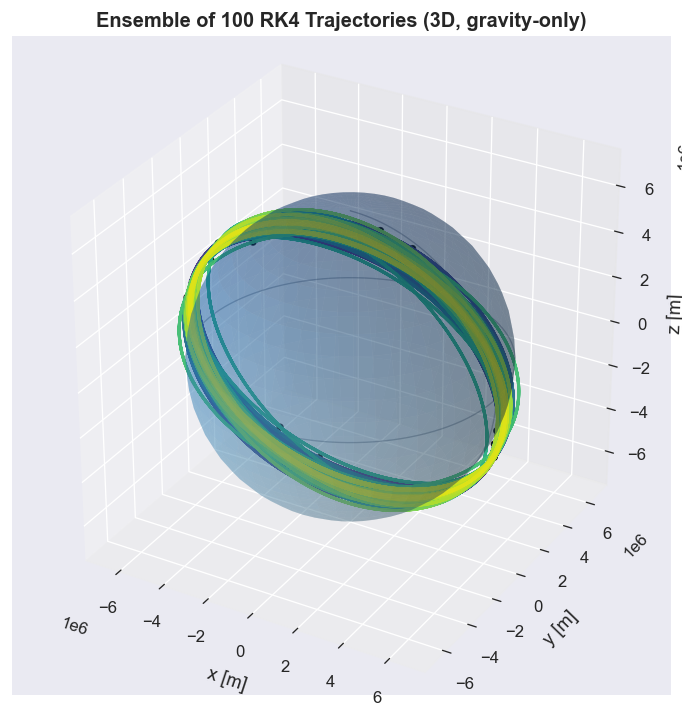

In [23]:
# --- Ensemble RK4 integration in 3D (gravity-only) ---
np.random.seed(42)  # reproducible
N = 100  # ensemble size

# Nominal initial state (reuse values from earlier)
inc_ens = np.deg2rad(30.0)
r_nom = np.array([r0_mag, 0.0, 0.0])
v_circ = np.sqrt(mu_earth / r0_mag)
v_nom = np.array([0.0, v_circ*np.cos(inc_ens), v_circ*np.sin(inc_ens)])
y_nom = np.hstack((r_nom, v_nom))

# Helper: Rodrigues' rotation formula
def rotate_vec(v, axis, angle):
    axis = np.asarray(axis, dtype=float)
    axis = axis / (np.linalg.norm(axis) + 1e-12)
    v = np.asarray(v, dtype=float)
    c, s = np.cos(angle), np.sin(angle)
    return v*c + np.cross(axis, v)*s + axis*np.dot(axis, v)*(1.0 - c)

# 3D gravity-only dynamics
def f_state_3d(y):
    r = y[:3]; v = y[3:]
    a = -mu_earth * r / (norm(r)**3)
    return np.hstack((v, a))

def rk4_step(y, dt, f):
    k1 = f(y)
    k2 = f(y + 0.5*dt*k1)
    k3 = f(y + 0.5*dt*k2)
    k4 = f(y + dt*k3)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def propagate_method(y0, t_end, dt, stepper, f):
    n = int(np.ceil(t_end/dt))
    ys = np.zeros((n+1, len(y0)))
    ts = np.zeros(n+1)
    ys[0] = y0.copy()
    for k in range(n):
        ys[k+1] = stepper(ys[k], dt, f)
        ts[k+1] = ts[k] + dt
    return ts, ys

# Perturbation settings (increase to spread trajectories more)
theta_sigma_deg = 5.0      # small random plane rotation (deg)
dv_par_sigma    = 10.0     # along-track m/s
dv_rad_sigma    = 5.0      # radial m/s
dv_norm_sigma   = 5.0      # out-of-plane m/s
phase_uniform   = True     # also randomize initial phase around nominal h-hat

t_end_ens = 18000.0  # seconds (~3 orbits to separate)
dt_ens    = 5.0

# Base orbital triad
r_hat = r_nom / norm(r_nom)
v_hat = v_nom / norm(v_nom)
h_hat = np.cross(r_nom, v_nom); h_hat = h_hat / (norm(h_hat) + 1e-12)

# Generate ensemble initial states with diverse perturbations
y0_list = []
for i in range(N):
    # Random small rotation of the orbital plane by angle theta about a random axis
    theta = np.deg2rad(np.random.normal(0.0, theta_sigma_deg))
    axis = np.random.normal(0.0, 1.0, size=3)
    r_i = rotate_vec(r_nom, axis, theta)
    v_i = rotate_vec(v_nom, axis, theta)
    # Optional random phase around (updated) angular momentum axis
    if phase_uniform:
        h_i = np.cross(r_i, v_i); h_i = h_i / (norm(h_i) + 1e-12)
        phi = np.random.uniform(0.0, 2*np.pi)
        r_i = rotate_vec(r_i, h_i, phi)
        v_i = rotate_vec(v_i, h_i, phi)
    # Small dv components in orbital frame (based on current r_i, v_i)
    rhat_i = r_i / (norm(r_i) + 1e-12)
    vhat_i = v_i / (norm(v_i) + 1e-12)
    hhat_i = np.cross(r_i, v_i); hhat_i = hhat_i / (norm(hhat_i) + 1e-12)
    dv = (np.random.normal(0.0, dv_par_sigma)  * vhat_i +
          np.random.normal(0.0, dv_rad_sigma)  * rhat_i +
          np.random.normal(0.0, dv_norm_sigma) * hhat_i)
    v_i = v_i + dv
    y0_list.append(np.hstack((r_i, v_i)))

# Integrate ensemble with RK4
traj_list = []
for y0i in y0_list:
    _, ysi = propagate_method(y0i, t_end_ens, dt_ens, rk4_step, f_state_3d)
    traj_list.append(ysi)

# Plot ensemble around Earth
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
draw_earth_3d(ax, R_earth, alpha=0.30)

# Distinct colors
if N <= 10:
    colors = plt.cm.tab10(np.arange(N))
else:
    colors = plt.cm.viridis(np.linspace(0.1, 0.95, N))

# Plot all trajectories with RAAN-like visual rotation
for i, ys in enumerate(traj_list):
    x, y, z = rotate_xyz(ys[:,0], ys[:,1], ys[:,2])
    ax.plot(x, y, z, color=colors[i], lw=1.8, alpha=0.95)

# Mark starting points to help count all members (rotated)
starts = np.array([rotate_xyz(ys[0,0], ys[0,1], ys[0,2]) for ys in traj_list])
starts = np.array(starts).reshape(-1,3)
ax.scatter(starts[:,0], starts[:,1], starts[:,2], color='k', s=12, alpha=0.8)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title(f'Ensemble of {N} RK4 Trajectories (3D, gravity-only)')

# Set context limits based on all trajectories
max_r_all = 0.0
for ys in traj_list:
    coords = np.vstack(rotate_xyz(ys[:,0], ys[:,1], ys[:,2])).T
    max_r_all = max(max_r_all, np.max(np.linalg.norm(coords, axis=1)))
pad = 0.1 * max_r_all
ax.set_xlim(-max_r_all-pad, max_r_all+pad)
ax.set_ylim(-max_r_all-pad, max_r_all+pad)
ax.set_zlim(-max_r_all-pad, max_r_all+pad)
set_equal_3d(ax)
plt.tight_layout()
plt.show()